In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Path

In [2]:
## Load Path
get_path = 'drive/MyDrive/Skip-GNN/'
data_path = get_path + 'data/IAV/'
edges_path = data_path + 'edges/'

# Import Libaries

In [3]:
## __init__
from __future__ import print_function
from __future__ import division

import os
import pandas as pd
import numpy as np

import math
import time
import copy ## train
# import argparse ## train

import scipy.sparse as sp
from scipy import sparse

import matplotlib.pyplot as plt ## train

## torch: layers, models, train
import torch
import torch.optim as optim ## train
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils import data

## sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
# from sklearn.preprocessing import normalize

# Utils

In [4]:
# Data Loader 
class Data_IAV(data.Dataset):
    # df : a list of data, which includes an index for the pair, an index for entity1 and entity2, from a list that combines all the entities. we want the 
    def __init__(self, idx_map, labels, df):
        'Initialization'
        self.labels = labels
        self.idx_map = idx_map
        self.df = df
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        idx1 = self.idx_map[self.df.iloc[index].Protein1_ID]
        idx2 = self.idx_map[self.df.iloc[index].Protein2_ID]
        y = self.labels[index]
        return y, (idx1, idx2)  

In [5]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

## load_data_link_prediction_IAV

In [6]:
def load_data_link_prediction_IAV(train_dataframe, inp_t, inp):
    
    print('Loading PPI dataset...')

    '''
        Load protein_list
    '''
    protein_list_df = pd.read_csv(data_path + 'protein_list.csv')
    # protein_list_len = len(protein_list_df)

    idx = protein_list_df['Protein1_ID'].tolist()
    idx = np.array(idx)
    idx_map = {j: i for i, j in enumerate(idx)} ## protein_list as a dictionary {uniprot_id: idx} = {3416: 0, 3428: 1, 3442: ...}

    # print(idx_map) 

    df_data_t = train_dataframe[train_dataframe.label == 1] 
    edges_unordered = df_data_t[['Protein1_ID', 'Protein2_ID']].values

    ## CALL READ_EMBEDDINGS METHOD HERE
    features = read_embeddings(inp_t, inp)
    # np.eye(protein_list_len) ## One-hot encoding

    edges = np.array(list(map(idx_map.get, edges_unordered.flatten()))).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(len(idx), len(idx)),
                    dtype=np.float32)
    
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    
    features = normalize(features) ## Row-normalize sparse matrix, def normalize(mx)
    # print(' ==================== Normalized Feature Embeddings ==================== ')
    # print(features)
    # print(features.shape)

    #create skip graph
    adj2 = adj.dot(adj)
    adj2 = adj2.sign()
    
    # Normalize skip graph
    adj2 = normalize_adj(adj2)
    adj2 = sparse_mx_to_torch_sparse_tensor(adj2)

    adj = adj + sp.eye(adj.shape[0])

    # Normalize original graph
    adj = normalize_adj(adj)

    features = torch.FloatTensor(features) ## Convert to FloatTensor
    
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    return adj, adj2, features, idx_map

## normalization

In [7]:
def normalize(mx): ## Sum of each row = 1
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1)) 
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def normalize_adj(adj):
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

In [8]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

### Read input data

In [9]:
############### INSERT EMBEDDING CODE HERE ###############
def read_embeddings(emb_type, emb_mtd):
  
    protein_list_df = pd.read_csv(data_path + 'protein_list.csv') ## data_path = 'drive/MyDrive/Skip-GNN/data/IAV/'
    protein_list_len = len(protein_list_df)
    print(protein_list_len)

    print('Embedding type: ' + emb_type) ## one-hot, protein, graph or concat
    print('Input method: ' + emb_mtd)

    ## "Weighted" adjacency matrix
    if (emb_type == 'hvppi') and (emb_mtd == 'hvppi'):
      read_emb = sparse.load_npz(data_path + 'hvppi_pred_adj_matrix_eye.npz') ## read.npz file
      features=read_emb.toarray() ## convert to array

    ### emb_mtd = inp
    if (emb_type == 'one-hot') and (emb_mtd == 'one-hot'):
        features = np.eye(protein_list_len) ## Returns a 2-D array with ones on the diagonal and zeros elsewhere

    ### GRAPH + PROTEIN EMBEDDINGS ### 
    elif emb_type == 'graph_protein_combi':
      edit_data_path = data_path + 'concat_embeddings/'
      read_emb = sparse.load_npz(edit_data_path + emb_mtd + '.npz')
      features=read_emb.toarray()

    else:
        ############### GRAPH EMBEDDINGS (read from sparse matrix) ###############
        ############### Read from data/IAV/graph_embeddings/ ###############
        ## node2vec, deepwalk, struc2vec, LINE (node attributes)

        edit_data_path = data_path + 'optim_graph_emb/'

        if emb_type == 'graph_combi':
          read_emb = sparse.load_npz(edit_data_path + emb_mtd + '.npz')
          features=read_emb.toarray()

        else:
          if emb_type == 'graph':
            emb = pd.read_csv(edit_data_path + emb_mtd + '.csv', skiprows=1, header = None).sort_values(by = [0]).set_index([0]) 

          elif emb_type == 'graph-sdne-grarep':
            emb = pd.read_csv(edit_data_path + emb_mtd + '.txt', sep=' ', skiprows=1, header = None).sort_values(by = [0]).set_index([0]) ## SDNE, GraRep

          ## Convert csv to array
          for i in np.setdiff1d(np.arange(protein_list_len), emb.index.values): ## setdiff1d: 1D array of values in ar1 that are not in ar2
            emb.loc[i] = (np.sum(emb.values, axis = 0)/emb.values.shape[0]) ## manually insert emb for protein indexes with no node2vec embedding
          
          features = emb.sort_index().values

    # print(' ==================== Feature Embeddings ==================== ')       
    # print(features)
    # print(features.shape)

    return features

In [10]:
def create_fold():

  '''
    Balanced Dataset
  '''
  # ## hold-out test set
  # test_df = pd.read_csv(data_path + 'edges/Sept2022/raw_b_holdout_test.csv')
  test_df = pd.read_csv(data_path + 'edges/Experimentally_Verified/test_V1.csv')
  # test_df = pd.read_csv(data_path + 'edges/Experimentally_Verified/test_V2.csv') ## sorted
  
  pos_org = pd.read_csv(data_path + 'edges/Sept2022/raw_b_pos_train_val.csv')
  neg_org = pd.read_csv(data_path + 'edges/Sept2022/raw_b_neg_train_val.csv')

  '''
    Unbalanced Dataset
  '''
  # test_df = pd.read_csv(edges_path + 'unbalanced_dataset/Sampled/test50.csv')
  # test_df = pd.read_csv(edges_path + 'unbalanced_dataset/new_test/test_1_10.csv')
  
  # pos_org = pd.read_csv(edges_path + 'unbalanced_dataset/positive_edges_train_val.csv') ## Standard
  # neg_org = pd.read_csv(edges_path + 'unbalanced_dataset/Sampled/neg_train_val50.csv')
  
  # neg_org = pd.read_csv(edges_path + 'unbalanced_dataset/new_test/neg_train_val_1_10.csv')

  '''
    Shuffle Data
  '''
  pos = shuffle(pos_org)
  neg = shuffle(neg_org)

  ## Train : Val = 9 : 1
  pos_val = pos.sample(frac = 0.1, replace = False) ## 10% of positive dataset
  pos_train = pos[~pos.index.isin(pos_val.index)]

  neg_val = neg.sample(frac = 0.1, replace = False) ## 10% of negative dataset
  neg_train = neg[~neg.index.isin(neg_val.index)]

  train_df = pd.concat([pos_train, neg_train], ignore_index=True)
  val_df = pd.concat([pos_val, neg_val], ignore_index=True)

  print('--Sampled new data--')

  return train_df, val_df, test_df

# Metrics

In [11]:
def calculate_metrics(y_label, y_pred, y_pred_f):

    # print(y_pred)

    # For binary classification
    TP, FP, TN, FN = 0, 0, 0, 0
    
    for i in range(len(y_label)):
        if y_label[i] == y_pred[i]:
            if y_label[i] == 1:
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if y_pred[i] == 1:
                FP = FP + 1
            else:
                FN = FN + 1
    
    accuracy = (TP + TN) / float(TP + TN + FP + FN)
    sensitivity = TP / float(TP + FN)
    specificity = TN / float(TN + FP)

    try:
      precision = TP / float(TP + FP)
      F1 = (2 * precision * sensitivity) / (precision + sensitivity)
    
    except ZeroDivisionError as e:
      print(e)
      precision = 0.0
      F1 = 0.0

    ROC_AUC = roc_auc_score(y_label, y_pred_f)
    PR_AUC = average_precision_score(y_label, y_pred_f)

    return [accuracy, sensitivity, specificity, precision, F1, ROC_AUC, PR_AUC]

# Layers

In [12]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))

        # print(self.weight)
        # print(self.weight.size())

        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        # print('support: ' + str(support.size()))

        output = torch.spmm(adj, support) ## matrix multiplication of sparse matrix
        
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

# Models

from layers import GraphConvolution

In [13]:
def reset_parameters(w):
    stdv = 1. / math.sqrt(w.size(0))
    w.data.uniform_(-stdv, stdv)

In [14]:
class SkipGNN(nn.Module):
    def __init__(self, nfeat, nhid1, nhid2, nhid_decode1, dropout):
        super(SkipGNN, self).__init__()
        
        '''
          nfeat = num input features
          nhid1 = num neurons in hidden layer 1
          nhid1 = num neurons in hidden layer 2
        '''
        
        # original graph
        self.o_gc1 = GraphConvolution(nfeat, nhid1)
        self.o_gc2 = GraphConvolution(nhid1, nhid2)
        
        # original graph for skip update
        self.o_gc1_s = GraphConvolution(nhid1, nhid1)
        
        #skip graph
        self.s_gc1 = GraphConvolution(nfeat, nhid1)
        
        #skip graph for original update
        self.s_gc1_o = GraphConvolution(nfeat, nhid1)
        self.s_gc2_o = GraphConvolution(nhid1, nhid2)
       
        self.dropout = dropout
        
        self.decoder1 = nn.Linear(nhid2 * 2, nhid_decode1)
        self.decoder2 = nn.Linear(nhid_decode1, 1)

    def forward(self, x, o_adj, s_adj, idx):
        
        o_x = F.relu(self.o_gc1(x, o_adj) + self.s_gc1_o(x, s_adj))       
        s_x = F.relu(self.s_gc1(x, s_adj) + self.o_gc1_s(o_x, o_adj))
        
        o_x = F.dropout(o_x, self.dropout, training = self.training)
        s_x = F.dropout(s_x, self.dropout, training = self.training)
        
        x = self.o_gc2(o_x, o_adj) + self.s_gc2_o(s_x, s_adj)
        # print(x)
        # print(x.size()) ## (len(protein_list) or features.shape[0], hidden2)
        
        feat_p1 = x[idx[0]] # the first biomedical entity embedding retrieved
        feat_p2 = x[idx[1]] # the second biomedical entity embedding retrieved
        # print(feat_p1)
        # print(feat_p2)
        # print('feat_p1: ' + str(feat_p1.size())) ## (batch size, hidden2) 
        # print('feat_p2: ' + str(feat_p2.size())) ## (batch size, hidden2)

        # feat = torch.cat((feat_p1, feat_p2), dim = 1) ## torch.cat: Concatenates the given sequence of seq tensors in the given dimension

        mul_feat = torch.mul(feat_p1, feat_p2) ## Hadamard product (Element-wise product)
        # add_feat = torch.add(feat_p1, feat_p2) ## Sum
        empty_feat = torch.zeros((256, feat_p1.size()[1])) ## Pad with zeros
        feat = torch.cat((mul_feat, empty_feat), dim = 1)

        # print(feat)
        # print(feat.size()) ## (batch size, p1.size()[1] + p2.size()[1]) 
        
        o = self.decoder1(feat)
        o = self.decoder2(o)
        return o, x

# Train

from utils import load_data_link_prediction_IAV, Data_IAV, create_fold

from models import SkipGNN

from metrics import calculate_metrics

In [15]:
def test(loader, model, features, adj, adj2, inp, m, loss_fct):
    
    model.eval() ## pytorch
    
    y_pred = []
    y_label = []

    for i, (label, inp) in enumerate(loader):
      
        output, _ = model(features, adj, adj2, inp)

        n = torch.squeeze(m(output)) ## m = torch.nn.Sigmoid()
            
        loss = loss_fct(n, label.float())  ## loss_fct = torch.nn.BCELoss()
    
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + output.flatten().tolist() ## y_pred in FLOAT
        outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)]) ## y_pred in BINARY, threshold = 0.5

        # print("y_label") ## True values
        # print(y_label)
        # print(len(y_label))

        # print("y_pred")
        # print(y_pred)
        # print(len(y_pred))

        # print("outputs")
        # print(outputs)
        # print(len(outputs))
        
    return roc_auc_score(y_label, y_pred), average_precision_score(y_label, y_pred), f1_score(y_label, outputs), loss, y_label, y_pred, outputs

In [16]:
def train(epochs = 15,
          batch_size = 256, ## 256
          lr = 1e-3,
          weight_decay = 5e-4, 
          hidden1 = 64, ## 64 
          hidden2 = 32, ## 32
          hidden_decode1 = 512, ## 512
          dropout = 0.5,
          emb_type='one-hot', ## one-hot, protein, graph or concat
          input_type = 'one-hot'): ## e.g. one-hot, node2vec, deepwalk, struc2vec

    ## Print hyper-parameters
    print(['epochs', 'bs', 'lr', 'hidden1', 'hidden2', 'hidden_decode1', 'dropout', 'emb type', 'input_type']) ## emb_t
    print([epochs, batch_size, lr, hidden1, hidden2, hidden_decode1, dropout, emb_type, input_type])
    print ('\n')

    '''
        Load data
        Test = 20% of 100% (whole dataset - pos+neg), Val = 12.5% of remaining 80%, Train = 87.5% of remaining 80%
    '''
    train_df, val_df, test_df = create_fold()
    
    print(train_df) 
  	
    ## from utils
    adj, adj2, features, idx_map = load_data_link_prediction_IAV(train_df, emb_type, input_type)  
   
    Data_class = Data_IAV
        
    params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 6,
                'drop_last' : True}

    training_set = Data_class(idx_map, train_df.label.values, train_df)
    train_loader = data.DataLoader(training_set, **params)

    validation_set = Data_class(idx_map, val_df.label.values, val_df)
    val_loader = data.DataLoader(validation_set, **params)

    test_set = Data_class(idx_map, test_df.label.values, test_df)
    test_loader = data.DataLoader(test_set, **params)

    '''
        Model   
    '''
    # Model and optimizer
    model = SkipGNN(nfeat=features.shape[1],
                nhid1 = hidden1,
                nhid2 = hidden2,
                nhid_decode1 = hidden_decode1,
                dropout= dropout)

    optimizer = optim.Adam(model.parameters(),
                           lr = lr,
                           weight_decay = weight_decay)
    
    loss_fct = torch.nn.BCELoss()
    m = torch.nn.Sigmoid()
        
    max_auc = 0
    model_max = copy.deepcopy(model)

    loss_history = []
    f1_valid_arr = []
    total_f1 = 0

    '''
        Train model
    '''
    t_total = time.time()
    print('Start Training...')
    
    for epoch in range(epochs):
        t = time.time()
        print ('-------- Epoch '+ str(epoch + 1)+' --------')
        y_pred_train = []
        y_label_train = []
        
        for i, (label, inp) in enumerate(train_loader): ## train_loader: torch.utils.data.dataloader.DataLoader object

            # print(label) ## tensor with size = batch_size, binary values 1 or 0
            # print(inp) ## tensor with size = batch_size
            
            #print(inp[0].shape)
            model.train()

            optimizer.zero_grad()
            output, _ = model(features, adj, adj2, inp)

            n = torch.squeeze(m(output))            
            loss_train = loss_fct(n, label.float()) ## loss_fct = torch.nn.BCELoss() ## Criterion that measures the Binary Cross Entropy between the target and the input probabilities
            loss_history.append(loss_train)
            loss_train.backward()
            optimizer.step()
            
            label_ids = label.to('cpu').numpy()
            y_label_train = y_label_train + label_ids.flatten().tolist()
            y_pred_train = y_pred_train + output.flatten().tolist()    
            
            if i % 100 == 0:
                print('epoch: ' + str(epoch+1) +'/ iteration: ' + str(i+1) + '/ loss_train: ' + str(loss_train.cpu().detach().numpy()))
            
        roc_train = roc_auc_score(y_label_train, y_pred_train)

        # validation after each epoch
        roc_val, prc_val, f1_val, loss_val, y_label_placeholder, y_pred_placeholder, y_pred_b_placeholder = test(val_loader, model, features, adj, adj2, inp, m, loss_fct)
        if roc_val > max_auc:
                model_max = copy.deepcopy(model)
                max_auc = roc_val
                #torch.save(model, path)    
        
        print('epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train.item()),
            'auroc_train: {:.4f}'.format(roc_train),
            'loss_val: {:.4f}'.format(loss_val.item()),
            'auroc_val: {:.4f}'.format(roc_val),
            'auprc_val: {:.4f}'.format(prc_val),
            'f1_val: {:.4f}'.format(f1_val),
            'time: {:.4f}s'.format(time.time() - t))   
        
        f1_valid_arr.append(f1_val)
        total_f1 = total_f1 + f1_val

    # print(loss_history) ## [tensor(0.6843, grad_fn=<BinaryCrossEntropyBackward0>), ...]
    ### Get value of loss_history tensor 
    loss_history_arr = []

    for i in range(0, len(loss_history)):
        get_tensor_val = loss_history[i].item()
        loss_history_arr.append(get_tensor_val)

    # print(loss_history_arr)
    plt.plot(loss_history_arr)        
            
    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

    # Testing
    print('--------- Testing ---------')
    auroc_test, prc_test, f1_test, loss_test, y_label_test, y_pred_test, y_pred_binary = test(test_loader, model_max, features, adj, adj2, inp, m, loss_fct)
    
    ## To-Do: Print Accuracy, Precision, Recall, Specificity, F-1 scores, ROC-AUC and PR-AUC here
    acc = calculate_metrics(y_label_test, y_pred_binary, y_pred_test)
    
    print('Accuracy, Sensitivity, Specificity, Precision, F1-Score, ROC-AUC, PR-AUC:\n', acc)
    
    print('loss_test: {:.4f}'.format(loss_test.item()),'auroc_test: {:.4f}'.format(auroc_test), 'auprc_test: {:.4f}'.format(prc_test), 'f1_test: {:.4f}'.format(f1_test))  
    print('\n')

    return acc

## Run program here

In [17]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [18]:
def run_prog(input_emb_type, input_graph_emb):
  
  eval_metrics = []

  ## 5-fold cross validation
  for i in range(0, 5):
    
    print('Iteration(train): ', (i+1))
    # acc = train(emb_type='hvppi', input_type='hvppi') ## Samples new data, overwrite hyperparams here
    acc = train(emb_type=input_emb_type, input_type=input_graph_emb) 
    
    eval_metrics.append(acc)
  
  print(eval_metrics)
  
  print("===================== " + input_graph_emb + " =====================")
  mean = np.array(eval_metrics).mean(axis=0) # Take the mean of each column
  mean = np.round(mean, 4)
  print('Mean: ' + str(mean)[1:-1])

  max = np.array(eval_metrics).max(axis=0)
  max = np.round(max, 4)
  print('Max: ' + str(max)[1:-1])

  min = np.array(eval_metrics).min(axis=0)
  min = np.round(min, 4)
  print('Min: ' + str(min)[1:-1])
  print("=======================================================")

  with open(get_path + '/Evaluation Results/SkipGNN_Oct2022_HPIDB_Negatome.txt', "a") as f:
    f.write(input_graph_emb + ': ' + str(mean) + '\n')

  # with open(get_path + '/Evaluation Results/SkipGNN_Unbalanced_Dataset_results.txt', "a") as f:
  #   f.write('==================== 1:10 ====================')
  #   f.write(input_graph_emb + ': ' + str(mean) + '\n')

In [19]:
# input_g_mtd_arr = ['dw-n2v-grarep-sdne', 'dw-n2v-grarep-line-sdne', 's2v-grarep-line-sdne', 'dw-n2v-s2v-grarep-sdne'] ## graph_combi
# input_g_mtd_arr = ['dw_nw8_wl32', 'n2v_p2_q0.5', 's2v_nw32_wl64', 'LINE_epochs25'] ## graph
input_g_mtd_arr = ['SDNE_a0_b10', 'GraRep_k2'] ## graph-sdne-grarep
# input_g_mtd_arr = ['SDNE_a0_b10'] 

SDNE_a0_b10
Iteration(train):  1
['epochs', 'bs', 'lr', 'hidden1', 'hidden2', 'hidden_decode1', 'dropout', 'emb type', 'input_type']
[15, 256, 0.001, 64, 32, 512, 0.5, 'graph-sdne-grarep', 'SDNE_a0_b10']


--Sampled new data--
     Protein1_ID Protein2_ID  label
0         P63151      P03508      1
1         Q14914      P03431      1
2         Q9UNQ2      P03431      1
3         P40926      P03433      1
4         P52294      P03485      1
...          ...         ...    ...
7221      P35408      C3W5X5      0
7222      Q8NAU1      P03485      0
7223      A1L3X0      P03466      0
7224      Q93015      P03468      0
7225      Q9BUH6      P0C0U1      0

[7226 rows x 3 columns]
Loading PPI dataset...
15685
Embedding type: graph-sdne-grarep
Input method: SDNE_a0_b10
Start Training...
-------- Epoch 1 --------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6869647
epoch: 0001 loss_train: 0.1056 auroc_train: 0.9293 loss_val: 0.2486 auroc_val: 0.9752 auprc_val: 0.9748 f1_val: 0.9025 time: 18.6300s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1503358
epoch: 0002 loss_train: 0.0835 auroc_train: 0.9935 loss_val: 0.2457 auroc_val: 0.9790 auprc_val: 0.9776 f1_val: 0.9194 time: 11.6058s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16796185
epoch: 0003 loss_train: 0.0705 auroc_train: 0.9951 loss_val: 0.1627 auroc_val: 0.9872 auprc_val: 0.9861 f1_val: 0.9241 time: 9.8262s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08122095
epoch: 0004 loss_train: 0.0559 auroc_train: 0.9960 loss_val: 0.1597 auroc_val: 0.9859 auprc_val: 0.9851 f1_val: 0.8920 time: 9.8036s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.058728844
epoch: 0005 loss_train: 0.0394 auroc_train: 0.9966 loss_val: 0.1812 auroc_val: 0.9884 auprc_val: 0.9876 f1_val: 0.9312 time: 9.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6960504
epoch: 0001 loss_train: 0.1597 auroc_train: 0.9230 loss_val: 0.2083 auroc_val: 0.9772 auprc_val: 0.9775 f1_val: 0.9043 time: 9.9951s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.11520236
epoch: 0002 loss_train: 0.0728 auroc_train: 0.9915 loss_val: 0.2734 auroc_val: 0.9697 auprc_val: 0.9751 f1_val: 0.9426 time: 10.0300s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.121638194
epoch: 0003 loss_train: 0.1068 auroc_train: 0.9938 loss_val: 0.2350 auroc_val: 0.9828 auprc_val: 0.9828 f1_val: 0.9423 time: 10.0089s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.097633444
epoch: 0004 loss_train: 0.0584 auroc_train: 0.9953 loss_val: 0.1502 auroc_val: 0.9870 auprc_val: 0.9863 f1_val: 0.9205 time: 10.0384s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.057545144
epoch: 0005 loss_train: 0.0657 auroc_train: 0.9959 loss_val: 0.1266 auroc_val: 0.9899 auprc_val: 0.9885 f1_val: 0.9239 time:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.69006014
epoch: 0001 loss_train: 0.1485 auroc_train: 0.9450 loss_val: 0.2423 auroc_val: 0.9793 auprc_val: 0.9782 f1_val: 0.8780 time: 10.0532s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15794012
epoch: 0002 loss_train: 0.0891 auroc_train: 0.9913 loss_val: 0.3917 auroc_val: 0.9559 auprc_val: 0.9650 f1_val: 0.9053 time: 10.0222s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09682389
epoch: 0003 loss_train: 0.0500 auroc_train: 0.9945 loss_val: 0.2408 auroc_val: 0.9792 auprc_val: 0.9788 f1_val: 0.9351 time: 9.9119s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12009427
epoch: 0004 loss_train: 0.0521 auroc_train: 0.9949 loss_val: 0.1056 auroc_val: 0.9835 auprc_val: 0.9826 f1_val: 0.9379 time: 9.9865s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.067494184
epoch: 0005 loss_train: 0.0774 auroc_train: 0.9961 loss_val: 0.2401 auroc_val: 0.9873 auprc_val: 0.9862 f1_val: 0.9081 time: 9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6980654
epoch: 0001 loss_train: 0.1496 auroc_train: 0.9342 loss_val: 0.2330 auroc_val: 0.9555 auprc_val: 0.9662 f1_val: 0.9118 time: 9.9811s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14946064
epoch: 0002 loss_train: 0.1440 auroc_train: 0.9910 loss_val: 0.2859 auroc_val: 0.9616 auprc_val: 0.9697 f1_val: 0.9064 time: 11.5307s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10587798
epoch: 0003 loss_train: 0.0701 auroc_train: 0.9927 loss_val: 0.2591 auroc_val: 0.9726 auprc_val: 0.9759 f1_val: 0.9277 time: 10.0518s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.0791115
epoch: 0004 loss_train: 0.0915 auroc_train: 0.9936 loss_val: 0.1988 auroc_val: 0.9830 auprc_val: 0.9829 f1_val: 0.9308 time: 9.9696s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.091606475
epoch: 0005 loss_train: 0.1006 auroc_train: 0.9949 loss_val: 0.1484 auroc_val: 0.9877 auprc_val: 0.9873 f1_val: 0.9377 time: 10.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6960887
epoch: 0001 loss_train: 0.1489 auroc_train: 0.9431 loss_val: 0.2278 auroc_val: 0.9482 auprc_val: 0.9621 f1_val: 0.9093 time: 10.0926s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13135889
epoch: 0002 loss_train: 0.2430 auroc_train: 0.9911 loss_val: 0.2725 auroc_val: 0.9700 auprc_val: 0.9722 f1_val: 0.9326 time: 9.9919s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11296381
epoch: 0003 loss_train: 0.0681 auroc_train: 0.9939 loss_val: 0.1886 auroc_val: 0.9820 auprc_val: 0.9811 f1_val: 0.9128 time: 10.0089s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08778382
epoch: 0004 loss_train: 0.0734 auroc_train: 0.9953 loss_val: 0.1683 auroc_val: 0.9913 auprc_val: 0.9902 f1_val: 0.9385 time: 9.9506s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06588861
epoch: 0005 loss_train: 0.0616 auroc_train: 0.9961 loss_val: 0.1683 auroc_val: 0.9913 auprc_val: 0.9906 f1_val: 0.9439 time: 9.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6969392
epoch: 0001 loss_train: 0.1086 auroc_train: 0.9463 loss_val: 0.2268 auroc_val: 0.9597 auprc_val: 0.9708 f1_val: 0.9188 time: 9.8862s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13863033
epoch: 0002 loss_train: 0.1713 auroc_train: 0.9914 loss_val: 0.2742 auroc_val: 0.9782 auprc_val: 0.9813 f1_val: 0.9086 time: 9.9218s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.053771663
epoch: 0003 loss_train: 0.0907 auroc_train: 0.9950 loss_val: 0.2282 auroc_val: 0.9814 auprc_val: 0.9846 f1_val: 0.9103 time: 9.8952s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.052758962
epoch: 0004 loss_train: 0.0764 auroc_train: 0.9962 loss_val: 0.2312 auroc_val: 0.9867 auprc_val: 0.9870 f1_val: 0.9091 time: 9.9481s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06994815
epoch: 0005 loss_train: 0.0375 auroc_train: 0.9967 loss_val: 0.2859 auroc_val: 0.9874 auprc_val: 0.9873 f1_val: 0.9239 time: 9.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7081331
epoch: 0001 loss_train: 0.1601 auroc_train: 0.9220 loss_val: 0.3811 auroc_val: 0.9333 auprc_val: 0.9573 f1_val: 0.8988 time: 10.0393s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13755858
epoch: 0002 loss_train: 0.1702 auroc_train: 0.9932 loss_val: 0.3618 auroc_val: 0.9446 auprc_val: 0.9603 f1_val: 0.9258 time: 9.9482s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.07670355
epoch: 0003 loss_train: 0.0602 auroc_train: 0.9948 loss_val: 0.3370 auroc_val: 0.9707 auprc_val: 0.9737 f1_val: 0.9243 time: 9.9550s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.043689787
epoch: 0004 loss_train: 0.0600 auroc_train: 0.9961 loss_val: 0.3295 auroc_val: 0.9715 auprc_val: 0.9735 f1_val: 0.9250 time: 9.7682s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08678981
epoch: 0005 loss_train: 0.0888 auroc_train: 0.9965 loss_val: 0.1394 auroc_val: 0.9731 auprc_val: 0.9751 f1_val: 0.9193 time: 9.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.70261383
epoch: 0001 loss_train: 0.1028 auroc_train: 0.9555 loss_val: 0.3743 auroc_val: 0.9662 auprc_val: 0.9721 f1_val: 0.9074 time: 11.4790s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12888242
epoch: 0002 loss_train: 0.0541 auroc_train: 0.9942 loss_val: 0.1443 auroc_val: 0.9861 auprc_val: 0.9847 f1_val: 0.9186 time: 9.9712s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.080924734
epoch: 0003 loss_train: 0.0454 auroc_train: 0.9953 loss_val: 0.1406 auroc_val: 0.9839 auprc_val: 0.9828 f1_val: 0.8976 time: 9.9609s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.045828983
epoch: 0004 loss_train: 0.0402 auroc_train: 0.9972 loss_val: 0.2781 auroc_val: 0.9821 auprc_val: 0.9805 f1_val: 0.9208 time: 9.9487s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.046689555
epoch: 0005 loss_train: 0.1086 auroc_train: 0.9969 loss_val: 0.2592 auroc_val: 0.9845 auprc_val: 0.9845 f1_val: 0.9185 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6957974
epoch: 0001 loss_train: 0.1239 auroc_train: 0.9355 loss_val: 0.4680 auroc_val: 0.9532 auprc_val: 0.9696 f1_val: 0.9073 time: 10.0418s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.076066
epoch: 0002 loss_train: 0.0815 auroc_train: 0.9921 loss_val: 0.2411 auroc_val: 0.9751 auprc_val: 0.9824 f1_val: 0.9349 time: 10.0564s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.056227744
epoch: 0003 loss_train: 0.0433 auroc_train: 0.9942 loss_val: 0.2291 auroc_val: 0.9772 auprc_val: 0.9829 f1_val: 0.9027 time: 10.0961s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.073580846
epoch: 0004 loss_train: 0.0796 auroc_train: 0.9963 loss_val: 0.1924 auroc_val: 0.9872 auprc_val: 0.9890 f1_val: 0.9304 time: 9.9934s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06786699
epoch: 0005 loss_train: 0.0431 auroc_train: 0.9965 loss_val: 0.1416 auroc_val: 0.9874 auprc_val: 0.9891 f1_val: 0.9304 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6990108
epoch: 0001 loss_train: 0.0988 auroc_train: 0.9231 loss_val: 0.2354 auroc_val: 0.9788 auprc_val: 0.9797 f1_val: 0.9096 time: 10.0813s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14693244
epoch: 0002 loss_train: 0.0876 auroc_train: 0.9932 loss_val: 0.2574 auroc_val: 0.9785 auprc_val: 0.9794 f1_val: 0.9288 time: 10.1248s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10256258
epoch: 0003 loss_train: 0.0412 auroc_train: 0.9958 loss_val: 0.3433 auroc_val: 0.9828 auprc_val: 0.9822 f1_val: 0.9040 time: 10.1717s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.104777135
epoch: 0004 loss_train: 0.0894 auroc_train: 0.9964 loss_val: 0.3332 auroc_val: 0.9802 auprc_val: 0.9797 f1_val: 0.8930 time: 10.0852s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.0580538
epoch: 0005 loss_train: 0.0341 auroc_train: 0.9967 loss_val: 0.1432 auroc_val: 0.9846 auprc_val: 0.9831 f1_val: 0.9290 time: 1

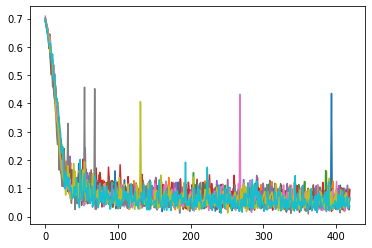

In [20]:
for i in range(len(input_g_mtd_arr)):
  
  # print(input_emb_type_arr[i]) # input_emb_type_arr = ['graph-sdne-grarep', 'graph', 'graph']
  
  print(input_g_mtd_arr[i])

  run_prog('graph-sdne-grarep', input_g_mtd_arr[i]) ## graph, graph-sdne-grarep, graph_combi

  print("************************************************** DONE " + str(i+1) + " **************************************************")


In [21]:
# eval_metrics = []

# ## 5-fold Cross Validation
# for i in range(0, 5):

#     print('Iteration(train): ', (i+1))
#     # acc = train(emb_type='hvppi', input_type='hvppi') ## Samples new data, overwrite hyperparams here
#     acc = train(emb_type='graph_combi', input_type='s2v-sdne') 
    
#     eval_metrics.append(acc)
#     print(eval_metrics)

# # save_mtd = 'node2vec_50p'
# # np.save(get_path + 'data/eval_matrices/' + save_mtd + '.npy', eval_metrics)

In [22]:
## 1 Iteration
# acc = train() ## Samples new data
# eval_metrics.append(acc)
# print(eval_metrics)

## Evaluation

In [23]:
## Append results here
# eval_arr = eval_metrics

In [24]:
# mean = np.array(eval_arr).mean(axis=0) # Take the mean of each column
# mean = np.round(mean, 4)
# print('Mean: ' + str(mean)[1:-1])

# max = np.array(eval_arr).max(axis=0)
# max = np.round(max, 4)
# print('Max: ' + str(max)[1:-1])

# min = np.array(eval_arr).min(axis=0)
# min = np.round(min, 4)
# print('Min: ' + str(min)[1:-1])

In [25]:
## CHANGE METHOD HERE
# mtd_name = 'combi_1'

In [26]:
# with open(get_path + 'GraphEmbCombi_results.txt', "a") as f:
#     f.write(mtd_name + ': ' + str(mean) + '\n')

In [27]:
############### DATASETS INPUT HERE ###############
# def create_fold():

#     # return train, val, test

#     # ### 0.99 threshold
#     # pos_org = pd.read_csv(data_path + 'edges/positive_edges_0.99.csv')
    
#     # # neg_org = pd.read_csv(data_path + 'edges/negative_edges_all.csv')
#     # neg_org = pd.read_csv(data_path + 'edges/negative_edges_12.5p.csv')
#     # neg_org = pd.read_csv(data_path + 'edges/negative_edges_25p.csv')

#     ## Struct2Graph
#     pos_org = pd.read_csv(data_path + 'edges/positive_edges_struct2graph.csv')
#     neg_org = pd.read_csv(data_path + 'edges/negative_edges_struct2graph.csv')
    
#     '''
#         Shuffle Data
#     '''
#     pos = shuffle(pos_org)
#     neg = shuffle(neg_org)

#     # Sample positive dataset (for _struct2graph)
#     pos = pos[:len(neg)]

#     ## Sample negative dataset
#     # neg = neg[:len(pos)]

#     # print(pos)
#     # print(len(pos))

#     ## Train : Val : Test = 67.5 : 12.5 : 20
#     # pos_test = pos.sample(frac = 0.2, replace = False) ## 20% of positive dataset
#     # pos_train_val = pos[~pos.index.isin(pos_test.index)]
#     # pos_val = pos_train_val.sample(frac = 0.125, replace = False) ## 12.5% of remaining 80% 
#     # pos_train = pos_train_val[~pos_train_val.index.isin(pos_val.index)]

#     # neg_test = neg.sample(frac = 0.2, replace = False) ## 20% of negative dataset
#     # neg_train_val = neg[~neg.index.isin(neg_test.index)]
#     # neg_val = neg_train_val.sample(frac = 0.125, replace = False) ## 12.5% of remaining 80% 
#     # neg_train = neg_train_val[~neg_train_val.index.isin(neg_val.index)]

#     ## Train : Val : Test = 8 : 1 : 1
#     pos_test = pos.sample(frac = 0.1, replace = False) ## 10% of positive dataset
#     pos_train_val = pos[~pos.index.isin(pos_test.index)]
#     pos_val = pos_train_val.sample(frac = 0.1, replace = False) ## 10% of remaining 80% 
#     pos_train = pos_train_val[~pos_train_val.index.isin(pos_val.index)]

#     neg_test = neg.sample(frac = 0.1, replace = False) 
#     neg_train_val = neg[~neg.index.isin(neg_test.index)]
#     neg_val = neg_train_val.sample(frac = 0.1, replace = False) 
#     neg_train = neg_train_val[~neg_train_val.index.isin(neg_val.index)]
    
#     train_df = pd.concat([pos_train, neg_train], ignore_index=True)
#     val_df = pd.concat([pos_val, neg_val], ignore_index=True)
#     test_df = pd.concat([pos_test, neg_test], ignore_index=True)


#     # print(len(train_df), len(val_df), len(test_df)) ## 4022, 574, 1148

#     ## Using random sampling of remaining pos and neg dataset as the test set
#     # test_size = 1148
#     # test_set = pd.read_csv()
#     # test_df = shuffle(test_set)
#     # test_df = test_df[:test_size] 

#     ## Held-out test set - used exclusively in the test dataset (Held-out)

#     print('--Sampled new data--')

#     return train_df, val_df, test_df